<a href="https://colab.research.google.com/github/icemeteor/NLP-Transformer/blob/main/NLP_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP Transformer Project

In [ ]:
# Prep
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [ ]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))

def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = np.array(output)
    del model  # free up space again
    return embeddings, words_pass


In [ ]:
# Attention calculation
def dot_product_attention(hidden_states, previous_state):

    # [T,d]*[d,N] -> [T,N]
    scores = np.matmul(previous_state, hidden_states.T)
    w_n = softmax(scores)

    # [T,N]*[N,d] -> [T,d]
    c_t = np.matmul(w_n, hidden_states)

    return w_n, c_t

def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

<ipython-input-2-07be0ad19719>:19: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


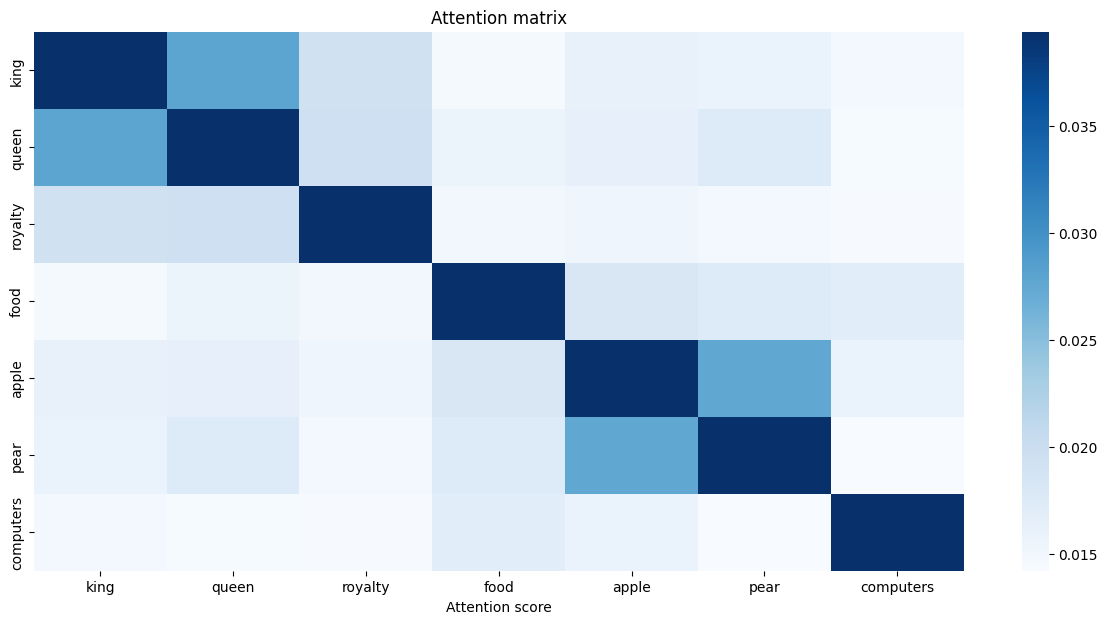

In [ ]:
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

We could detect the relationships between apple, pear and a little less food; as one cluster. Then another cluster of the royalty, and finally commputers alone, so it detected what it is supposed to!

## Self attention

In [ ]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = re.sub(r"[^\w\s]", "", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words

In order to see self attention, we just need to do what we did before! But now we will use a variant called **Scaled self attention** which is the one Transformers almost use:

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

In [7]:
def scaled_dot_product_attention(query, key, value):
    d_k = key.shape[-1]
    logits = np.matmul(query, np.swapaxes(key, -2, -1))
    scaled_logits = logits / np.sqrt(d_k)
    attention_weights = softmax(scaled_logits, axis=-1)
    value = np.matmul(attention_weights, value)
    return value, attention_weights

In [17]:
sentence = "I drink coke, but eat fish"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

<ipython-input-2-07be0ad19719>:19: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


(1, 6, 300)

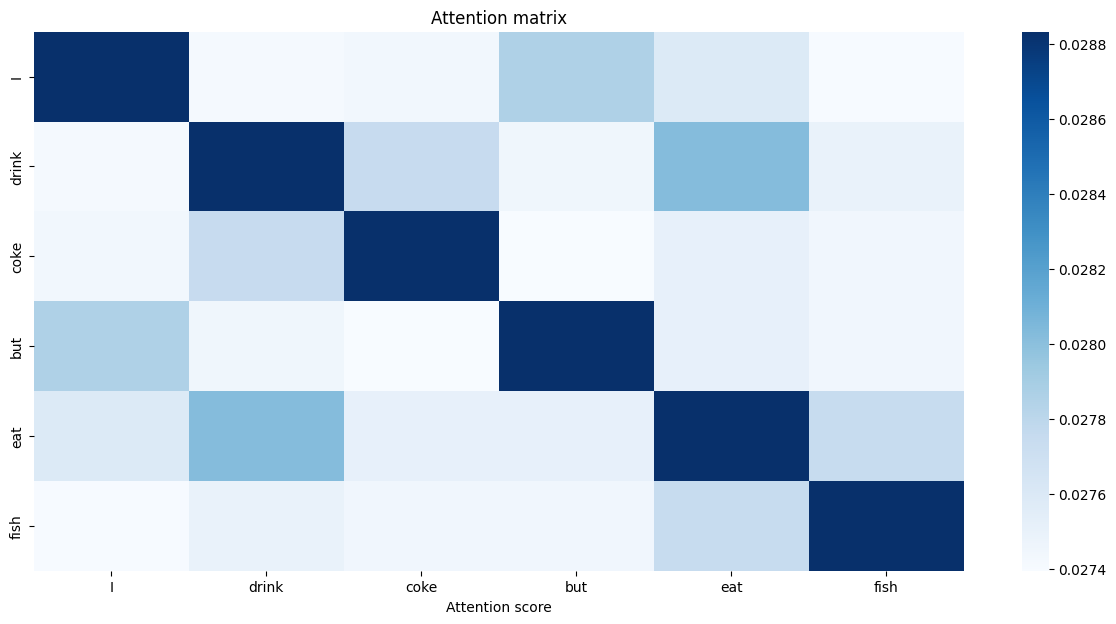

In [18]:
Q = K = V = word_embeddings   # Para no entrenar

# calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = re.sub(r"[^\w\s]", "", sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)